# Final Project - 
We are going to analyze immigration data by country, with a few questions in mind
- How well can we classify whether a country has a positive net immigration number or negative net immigration number?
- What factors are the most indicative of influx / outflux of people?
- Is there a qualitative difference in the factors that lead to outflux vs influx?

## Part 1: Imports and Data Setup
We have the following datasets to setup
- conflict_index.csv (Country, Conflict Index)
- gpi_2024.csv (Country, GPI_2024)
- countries_by_population_2022.csv (Country, Population)
- social_progress_scores.csv (Country, ...)
- net_immigration.csv (Country, Absolute Net Immigrants)
- gdp_per_capita_country_2022.csv (Country, GDP_per_Capita)
All data is from 2022 or 2023. It is assumed that values will not significantly differ by the time difference and that
Immigration trends are macro level enough as to ignore time delay. We will do some analysis to filter out
the most significant local conflicts (ex: Ukraine) and see how that affects our analysis
See the notes file for more information on the data being used

In [1137]:
import pandas as pd
import glob
import os

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.svm import LinearSVC

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, GridSearchCV

from matplotlib.colors import Normalize

In [1138]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'data')

In [1139]:
def import_data(directory):
    # Create a dictionary to store DataFrames
    data_frames = {}

    # Use glob to find all CSV files in the specified directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    # Iterate over the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        # Extract the file name without extension to use as the key
        file_name = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_csv(file)
        
        # Store the DataFrame in the dictionary
        data_frames[file_name] = df

        print(f"CSV file {file} has been successfully loaded into a pandas DataFrame.\n")

    return data_frames

In [1140]:
data_frames = import_data(data_directory)

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/conflict_index.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/gpi_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/gdp_per_capita_country_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/social_progress_scores.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/countries_by_population_2022.csv has been successfully loaded into a pandas DataFrame.

CSV file /home/drodriq/Source/Python/Coursework/CU Boulder/ML/Course1/final/data/net_immigration.csv has been successfully loaded into a pandas DataFrame.



/tmp/ipykernel_43292/2982150723.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [1150]:
# SVM Helper Functions
def linear_plot(X, y, w=None, b=None, xlabel=None, ylabel=None, title=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==False else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    scatter = ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    # Add labels to axes
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    if title:
        ax.set_title(title, fontsize=14)
    
    ax.grid(alpha=0.25)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Class 0', 
                                  markerfacecolor=mycolors["red"], markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', label='Class 1', 
                                  markerfacecolor=mycolors["blue"], markersize=10)]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.show()
def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==False else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.5,2])
    ax.set_ylim([-1.5,2])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

In [1151]:
# Clean Data
## We need to make sure the data frames include the same countries and have the same lengths. Sorting was already done via the CSV files,
## but we will ensure the names match up at the end

In [1152]:
# Make sure all countries match what is in social index score list
def filter_countries(df, country_list):
    # Filter each DataFrame to include only rows with countries in country_list
    df = df[df['Country'].isin(country_list)]
    return df

country_list = data_frames["net_immigration"]["Country"].tolist()
for name, df in data_frames.items():
    data_frames[name] = filter_countries(df, country_list)

In [1153]:
shortest_num = min([len(frame) for frame in data_frames.values()])
print(shortest_num)
name_of_shortest = [key for key,value in data_frames.items() if len(value) == shortest_num]
new_country_list = data_frames[name_of_shortest[0]]["Country"].tolist()
for name, df in data_frames.items():
    data_frames[name] = filter_countries(df, new_country_list)

139


In [1154]:
def assert_equal_lengths(data_frames):
    lengths = [len(df) for df in data_frames.values()]
    print(lengths)
    assert all(length == lengths[0] for length in lengths), "Not all DataFrames have the same length"

assert_equal_lengths(data_frames)

[139, 139, 139, 139, 139, 139]


In [1155]:
def assert_columns_match(data_frames):
    countries = []
    for df in data_frames.values():
        countries.append(df["Country"].tolist())
    for i in range(len(countries)):
        assert countries[0][i] == countries[1][i] == countries[2][i] == countries[3][i]

assert_columns_match(data_frames)

In [1156]:
# Join Frames
master_frame = pd.merge(data_frames["social_progress_scores"], data_frames["countries_by_population_2022"], on='Country', how='left')
master_frame = pd.merge(master_frame, data_frames["gdp_per_capita_country_2022"], on='Country', how='left')
master_frame = pd.merge(master_frame, data_frames["net_immigration"], on='Country', how='left')
master_frame = pd.merge(master_frame, data_frames["conflict_index"], on='Country', how='left')
master_frame = pd.merge(master_frame, data_frames["gpi_2022"], on='Country', how='left')

master_frame = master_frame[master_frame['Absolute Net Immigrants'] != 0]
master_frame = master_frame[master_frame['GDP_per_Capita'] != 0]
master_frame['Conflict_Index'] = master_frame['Conflict_Index'].astype(int)

master_frame.columns = master_frame.columns.str.replace(' ', '_')
print(master_frame.columns)
print(master_frame.info())

Index(['Country', 'Social_Progress_Score', 'Basic_Human_Needs',
       'Foundations_of_Wellbeing', 'Opportunity',
       'Nutrition_and_Basic_Medical_Care', 'Water_and_Sanitation', 'Shelter',
       'Personal_Safety', 'Access_to_Basic_Knowledge',
       'Access_to_Information_and_Communications', 'Health_and_Wellness',
       'Environmental_Quality', 'Personal_Rights',
       'Personal_Freedom_and_Choice', 'Inclusiveness',
       'Access_to_Advanced_Education', 'Population', 'GDP_per_Capita',
       'Absolute_Net_Immigrants', 'Conflict_Score', 'Conflict_Index',
       'GPI_2022'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 0 to 138
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   130 non-null    object 
 1   Social_Progress_Score                     130 non-null    float64
 2   B

In [1157]:
# Lets see how much of the global population we captured before moving forward
data_pop = sum(master_frame["Population"])
world_pop_2022 = 7951000000
percent_represented = (data_pop/world_pop_2022)*100
print(percent_represented)

89.40904059866683


## Part 2: Some Visualization
Lets take a look at some of our code to see what we have. 
We will start by visualizing what countries people are immigrating to vs leaving and see if we can
get a sense of the magnitudes.Then we will look at the conflict severity by country. From the source, GPI scores range from 1-5, with 5being the most dangerous.

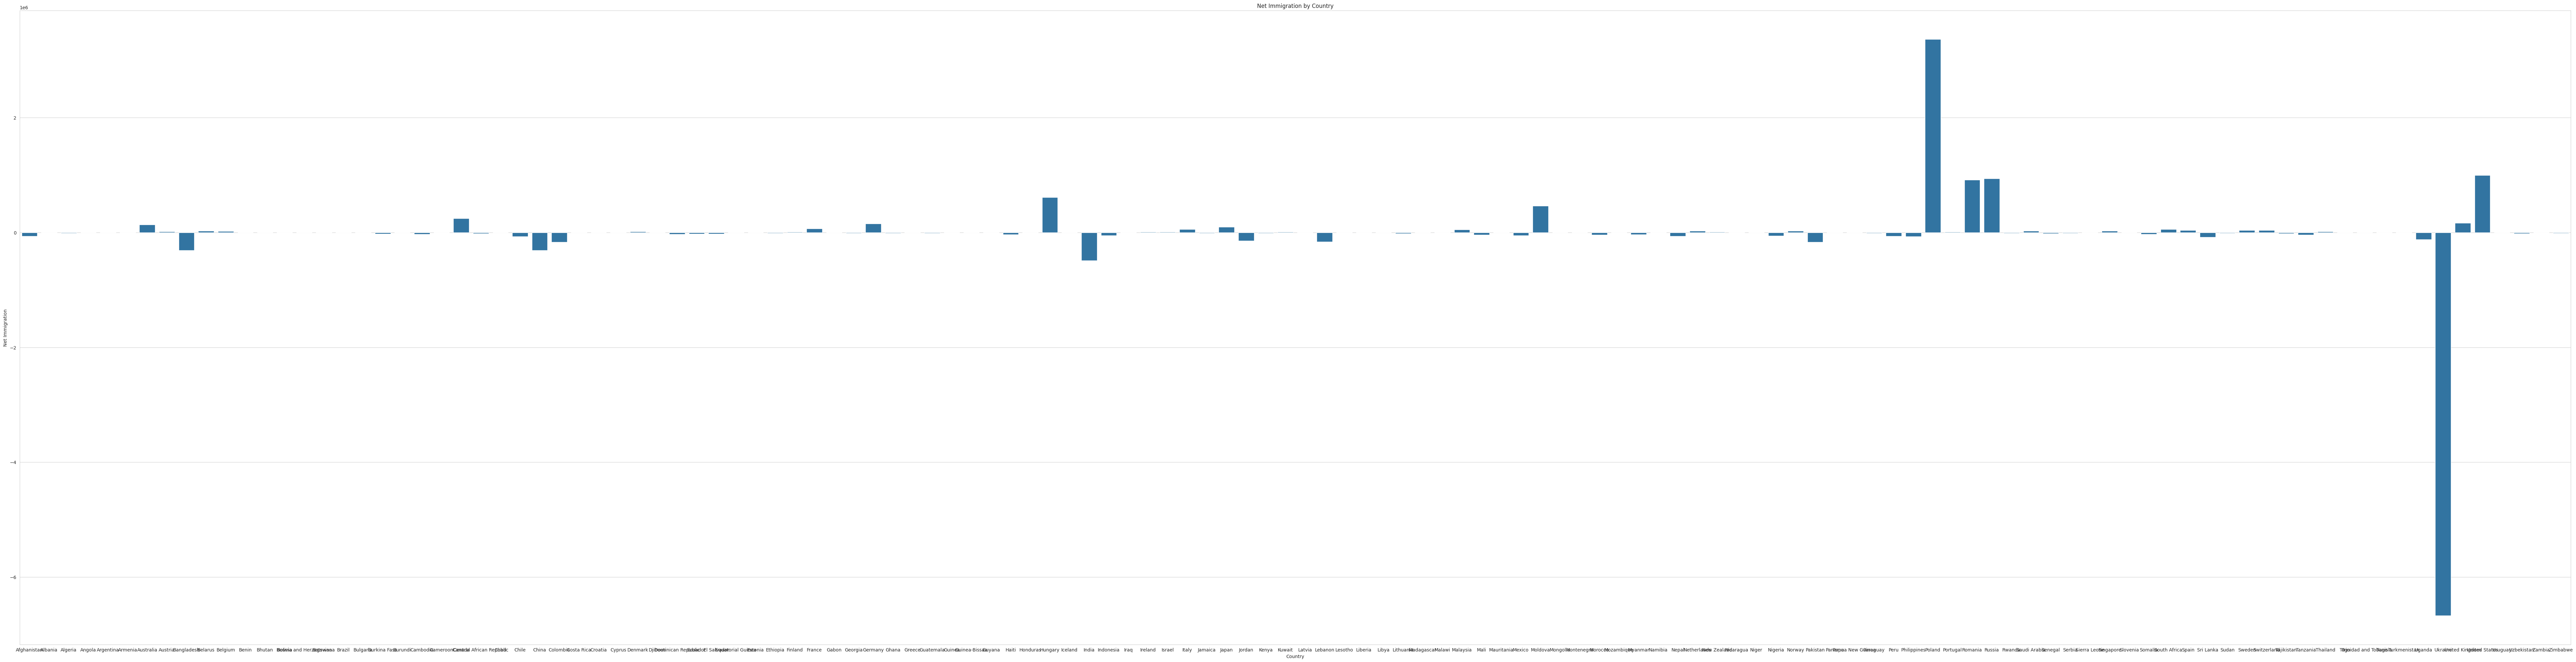

In [1158]:
# Plot net immigration to and from by country
df = master_frame[["Country", "Absolute_Net_Immigrants"]]

sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(100, 25))
bar_plot = sns.barplot(x='Country', y='Absolute_Net_Immigrants', data=df)

# Add titles and labels
plt.title('Net Immigration by Country')
plt.xlabel('Country')
plt.ylabel('Net Immigration')

# Show the plot
plt.show()

AS we can see from this admittedly hard to read graph, this data is highly variable. Intuitively, I am suspecting that there is a distribution to analyze here, possibly a power law or exponential fit for the data. I think it would be valuable to categorize this before moving forward. We will compare immigration number distributions to population. 

Calculating best minimal value for power law fit


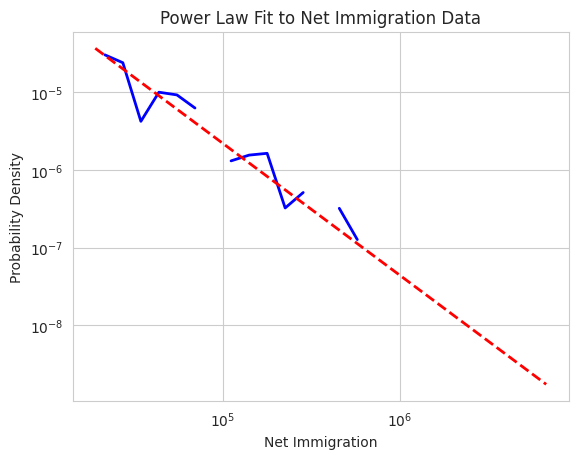

Log-likelihood ratio: 55.36666319373128
p-value: 0.001986761060614055
Alpha: 1.7000339206149655
Xmin: 18999.0
Median: 11999.0


In [1159]:
import powerlaw

# Extract the Net Immigration column
net_immigration = df['Absolute_Net_Immigrants'].abs()  # Use absolute values to avoid negative numbers

# Fit the power law distribution
fit = powerlaw.Fit(net_immigration)

# Plot the data and the power law fit
fig, ax = plt.subplots()
fit.plot_pdf(ax=ax, color='b', linewidth=2)
fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', linewidth=2)

# Add labels and title
ax.set_xlabel('Net Immigration')
ax.set_ylabel('Probability Density')
ax.set_title('Power Law Fit to Net Immigration Data')

# Show the plot
plt.show()

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio: {R}")
print(f"p-value: {p}")

# Print the alpha value and other statistics
print(f"Alpha: {fit.power_law.alpha}")
print(f"Xmin: {fit.power_law.xmin}")
print(f"Median: {net_immigration.median()}")

#### Interpretation
A positive log-liklihood value indicates the power law distribution is a better fit than a simple exponential. The p value < 0.05 indicates the variation is quite significant.
Alpha can be interpreted as the "length of the tail" in a distribution. We can visualize this by comparing to a common bell-curve, which has no tail, vs a bell curve where extreme outliers are far more common. For instance, human intelligence (as measured by IQ) follows a standard bell-curve, but a fatter-tailed bell curve would mean far more people have extremely high or extremely low IQs tahn compared to a simple gaussian. Here, an alpha of 1.7 indicates our data is indeed long-tailed, but not extremely so.
Xmin is the minimum value above which the power law behavior is observed. This value is a bit above the median value, meaning less than half the data follows the power law as so. 

Calculating best minimal value for power law fit


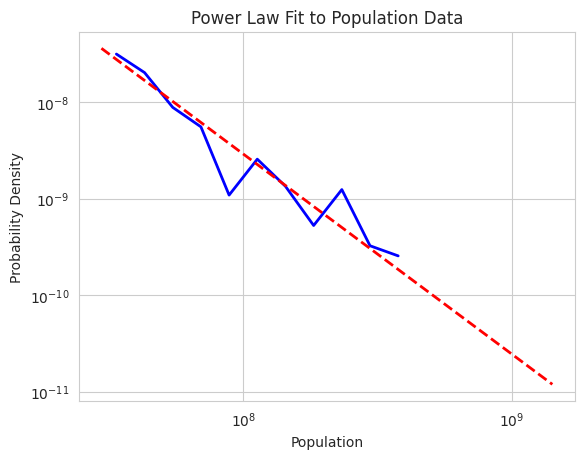

Log-likelihood ratio: 22.144663870615787
p-value: 0.010422599641531577
Alpha: 2.072372105047802
Xmin: 29611714.0
Median: 12622846.5


In [1160]:
# Extract the Net Immigration column
df = master_frame[["Country", "Population"]]
population = df['Population'].abs()  # Use absolute values to avoid negative numbers

# Fit the power law distribution
fit = powerlaw.Fit(population)

# Plot the data and the power law fit
fig, ax = plt.subplots()
fit.plot_pdf(ax=ax, color='b', linewidth=2)
fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', linewidth=2)

# Add labels and title
ax.set_xlabel('Population')
ax.set_ylabel('Probability Density')
ax.set_title('Power Law Fit to Population Data')

# Show the plot
plt.show()

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio: {R}")
print(f"p-value: {p}")

# Print the alpha value and other statistics
print(f"Alpha: {fit.power_law.alpha}")
print(f"Xmin: {fit.power_law.xmin}")
print(f"Median: {population.median()}")

Here we see that country population follows a clean power law, but the Xmin places it above 30,547,580. From the data, we see that is only about 50 countries or so, but the trendline is still interesting. The alpha value indicates a far more dramatic tail for population data than for immigration data, and a less significant fit for a power law than for an exponential.

What this means for our analysis is that although some aspects of population follows a cleaner fit for a simple power law analysis, other aspects don't when compared to immigration data. The lines are certainly not the same, more population does not indicate more net or loss of immigrants. Something more is at work here, but also we may need to normalize our data to population. 

Calculating best minimal value for power law fit


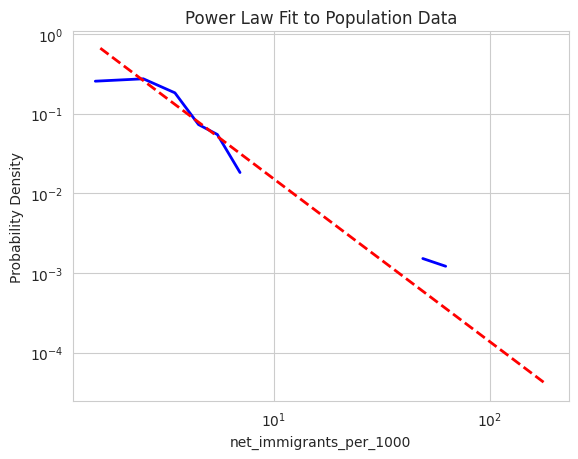

Log-likelihood ratio: 61.32324850765753
p-value: 1.5452038474794433e-08
Alpha: 2.0450487413352816
Xmin: 1.581994941979235
Median: 0.9936081724181886


In [1161]:
# Normalizing our data. Lets start by creating a new column that is absolute net immigrants into net immigrants per 1000
master_frame['net_immigrants_per_1000'] = (master_frame['Absolute_Net_Immigrants'] / master_frame['Population']) * 1000

df = master_frame[["Country", "net_immigrants_per_1000"]]
net_immigrants_per_1000 = df['net_immigrants_per_1000'].abs()  # Use absolute values to avoid negative numbers

# Fit the power law distribution
fit = powerlaw.Fit(net_immigrants_per_1000)

# Plot the data and the power law fit
fig, ax = plt.subplots()
fit.plot_pdf(ax=ax, color='b', linewidth=2)
fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', linewidth=2)

# Add labels and title
ax.set_xlabel('net_immigrants_per_1000')
ax.set_ylabel('Probability Density')
ax.set_title('Power Law Fit to Population Data')

# Show the plot
plt.show()

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio: {R}")
print(f"p-value: {p}")

# Print the alpha value and other statistics
print(f"Alpha: {fit.power_law.alpha}")
print(f"Xmin: {fit.power_law.xmin}")
median_ = net_immigrants_per_1000.median()
print(f"Median: {median_}")

Here we see that normalizing our net immigration numbers to population gives us a far higher Log-likelihood, indicating the power law fit is even better than before. The p-value is extremely small, indicating the difference is statistically significant. Our alpha is closer to that of population. Our Xmin is quite a bit higher than the median value, meaning our exponential fit is only good for less than half our data, though. We will carry on with our analysis. 

Now lets visualize the conflict levels across countries. We have two indexes to compare: GPI and ACLED's Conflict Index. Review the sources.txt file in /data for more information about the data sources. 

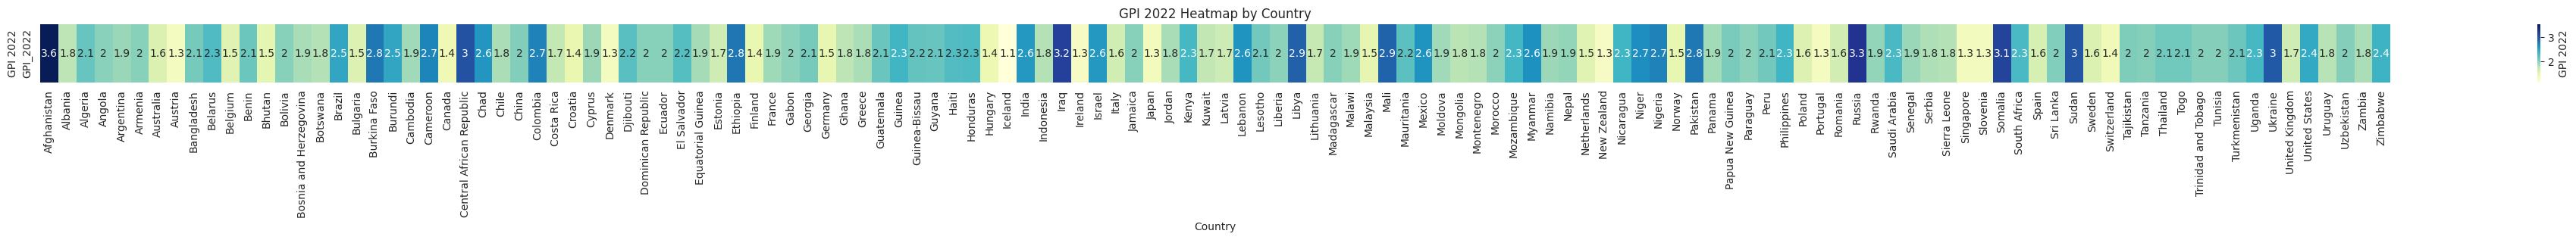

In [1162]:
df = master_frame[["Country", "GPI_2022"]]
# Set the Country column as the index
df.set_index('Country', inplace=True)

# Create the heatmap
plt.figure(figsize=(50, 1))  # Adjust the figure size as needed
sns.heatmap(df.T, annot=True, cmap="YlGnBu", cbar_kws={'label': 'GPI 2022'})

# Add titles and labels
plt.title('GPI 2022 Heatmap by Country')
plt.xlabel('Country')
plt.ylabel('GPI 2022')

# Show the plot
plt.show()

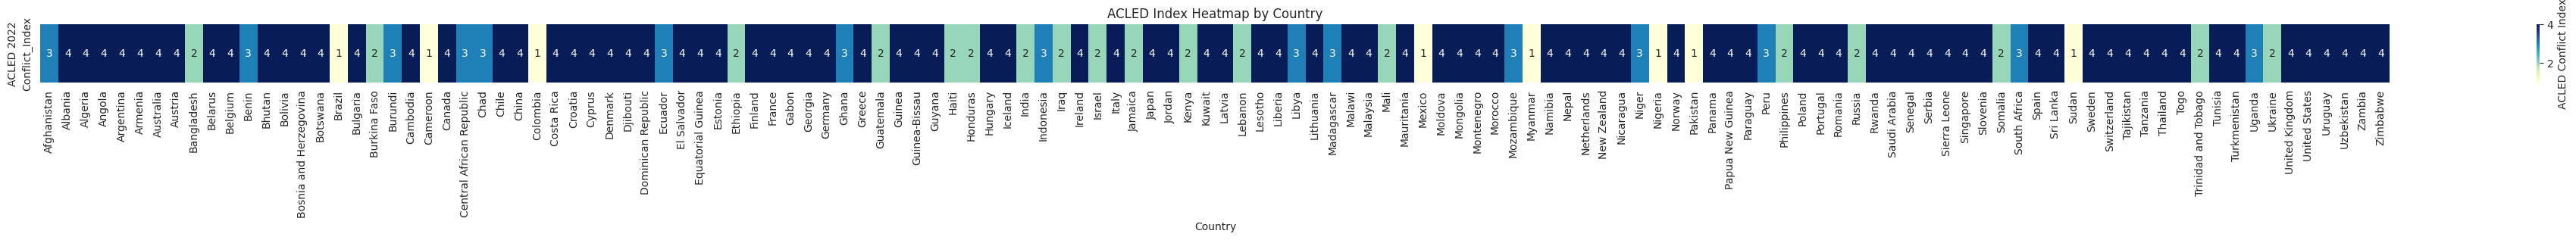

In [1163]:
df = master_frame[["Country", "Conflict_Index"]]
# Set the Country column as the index
df.set_index('Country', inplace=True)

# Create the heatmap
plt.figure(figsize=(50, 1))  # Adjust the figure size as needed
sns.heatmap(df.T, annot=True, cmap="YlGnBu", cbar_kws={'label': 'ACLED Conflict Index'})

# Add titles and labels
plt.title('ACLED Index Heatmap by Country')
plt.xlabel('Country')
plt.ylabel('ACLED 2022')

# Show the plot
plt.show()

In [1164]:
# Filter the DataFrame for countries with GPI >= 2.9
df = master_frame[["Country", "GPI_2022"]]
median_ = df["GPI_2022"].median()
print(median_)

high_conflict_data = df[df['GPI_2022'] > 2.95]
middle_conflict_data = df[df['GPI_2022'] < 2.95]
middle_conflict_data = middle_conflict_data[middle_conflict_data['GPI_2022'] >= median_]
low_conflict_data = df[df['GPI_2022'] < median_]

# Create a list of the countries that meet the criteria
high_conflict_countries = high_conflict_data['Country'].tolist()
middle_conflict_countries = middle_conflict_data['Country'].tolist()
low_conflict_countries = low_conflict_data['Country'].tolist()

print(f"GPI High Conflict Countries: {high_conflict_countries}")
print(f"GPI Middle Conflict Countries: {middle_conflict_countries}")
print(f"GPI Low Conflict Countries: {low_conflict_countries}")

1.9885000000000002
GPI High Conflict Countries: ['Afghanistan', 'Central African Republic', 'Iraq', 'Russia', 'Somalia', 'Sudan', 'Ukraine']
GPI Middle Conflict Countries: ['Algeria', 'Armenia', 'Bangladesh', 'Belarus', 'Benin', 'Bolivia', 'Brazil', 'Burkina Faso', 'Burundi', 'Cameroon', 'Chad', 'China', 'Colombia', 'Djibouti', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'Georgia', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Israel', 'Jamaica', 'Kenya', 'Lebanon', 'Lesotho', 'Libya', 'Madagascar', 'Mali', 'Mauritania', 'Mexico', 'Mozambique', 'Myanmar', 'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Peru', 'Philippines', 'Saudi Arabia', 'South Africa', 'Sri Lanka', 'Tajikistan', 'Tanzania', 'Thailand', 'Togo', 'Trinidad and Tobago', 'Tunisia', 'Turkmenistan', 'Uganda', 'United States', 'Uzbekistan', 'Zimbabwe']
GPI Low Conflict Countries: ['Albania', 'Angola', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Bhutan', 'Bosnia 

In [1165]:
# Filter the DataFrame for countries with GPI >= 2.9
df = master_frame[["Country", "Conflict_Index"]]
median_ = df["Conflict_Index"].median()

high_conflict_data = df[df['Conflict_Index'] == 1]
middle_conflict_data = df[df['Conflict_Index'] > 1]
middle_conflict_data = middle_conflict_data[middle_conflict_data['Conflict_Index'] <= 3]
low_conflict_data = df[df['Conflict_Index'] > 3]

# Create a list of the countries that meet the criteria
high_conflict_countries = high_conflict_data['Country'].tolist()
middle_conflict_countries = middle_conflict_data['Country'].tolist()
low_conflict_countries = low_conflict_data['Country'].tolist()

print(f"ACLED High Conflict Countries: {high_conflict_countries}")
print(f"ACLED Middle Conflict Countries: {middle_conflict_countries}")
print(f"ACLED Low Conflict Countries: {low_conflict_countries}")

ACLED High Conflict Countries: ['Brazil', 'Cameroon', 'Colombia', 'Mexico', 'Myanmar', 'Nigeria', 'Pakistan', 'Sudan']
ACLED Middle Conflict Countries: ['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Central African Republic', 'Chad', 'Ecuador', 'Ethiopia', 'Ghana', 'Guatemala', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iraq', 'Israel', 'Jamaica', 'Kenya', 'Lebanon', 'Libya', 'Madagascar', 'Mali', 'Mozambique', 'Niger', 'Peru', 'Philippines', 'Russia', 'Somalia', 'South Africa', 'Trinidad and Tobago', 'Uganda', 'Ukraine']
ACLED Low Conflict Countries: ['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Belarus', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'China', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Djibouti', 'Dominican Republic', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Greece', 'Guinea', 'Guinea-

#### Wow!
Rating a country by danger or conflict level is not as objectively simple as may be assumed. Look no further than the fierce debate to classify the Israel-Palestine conflict. There is a lot of political influence and routine bias that plays into this, on top of differences in methodology even if purely objective quantites are used. We see that among these two rating agencies their classifications are very different. Mexico is in higher conflict than Ukraine? The US is the lowest conflict level here, but far above the median in GPI? Very curious differences here, and many come down to methodology.

Lets see which one is a better predictor for immigration.

# Part 3: Linear Regression

## Naive Linear Regression

In [1166]:
# Lets see what factors are the most important
best_predictor=''
best_r_squared=0
r_squareds=[]

# target var
y = master_frame['net_immigrants_per_1000']

for feature in master_frame.columns:
    if feature != 'Absolute_Net_Immigrants' and feature != "Country" and feature != "net_immigrants_per_1000":
        X = master_frame[[feature]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        r_squareds.append((feature, r_squared))
        
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_predictor = feature

sorted_r = sorted(r_squareds, key=lambda x: x[1])
sorted_r = reversed(sorted_r)
for item in sorted_r:
    print(f"{item[0]}: {item[1]}")

Conflict_Score: 0.10895779687670593
GPI_2022: 0.05058920214710094
Conflict_Index: 0.032357087905880655
Personal_Safety: 0.019569004736635698
Basic_Human_Needs: 0.007364191631899719
Personal_Rights: 0.007316387980505712
Social_Progress_Score: 0.0072071041756589516
Access_to_Basic_Knowledge: 0.006730149622908521
Opportunity: 0.006062665012145807
Foundations_of_Wellbeing: 0.005970234035150179
Inclusiveness: 0.005948968770637886
Nutrition_and_Basic_Medical_Care: 0.005452328354709657
Access_to_Information_and_Communications: 0.00543999425461128
Health_and_Wellness: 0.004759605449223714
Personal_Freedom_and_Choice: 0.004744561006321146
Water_and_Sanitation: 0.004409028734930542
GDP_per_Capita: 0.004237083760188054
Shelter: 0.0041928547428556895
Access_to_Advanced_Education: 0.0025855032343542472
Environmental_Quality: 0.0019225782294628457
Population: 0.00029719906252001493


## Hypothesis
Conflict score is by far the best predictor, but even so the r-squared value is quite low. Our hypothesis above was that the reasons a country may have a high net negative immigration level and the reasons a country might have a high net positive immigration level are qualitatively different. Lets test this below.

In [1167]:
best_predictor = ''
best_r_squared = 0
r_squareds = []

net_loss_data = master_frame[master_frame['net_immigrants_per_1000'] < 0]
# Target variable
y = net_loss_data['net_immigrants_per_1000']
print(f"Number of net loss countries: {len(y)}")

for feature in net_loss_data.columns:
    if feature != 'Absolute_Net_Immigrants' and feature != "Country" and feature != "net_immigrants_per_1000":
        X = net_loss_data[[feature]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        r_squareds.append((feature, r_squared))

        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_predictor = feature

sorted_r = sorted(r_squareds, key=lambda x: x[1])
sorted_r = reversed(sorted_r)
for item in sorted_r:
    print(f"{item[0]}: {item[1]}")

Number of net loss countries: 81
Conflict_Score: 0.20789529055786538
Access_to_Advanced_Education: 0.05680533863025827
GPI_2022: 0.0438732311277924
Access_to_Basic_Knowledge: 0.029052954636391903
Opportunity: 0.024292733068638883
Social_Progress_Score: 0.023514495114269285
Foundations_of_Wellbeing: 0.02185981124650771
Shelter: 0.021779920683800746
Access_to_Information_and_Communications: 0.021662682655813836
Personal_Freedom_and_Choice: 0.02126708153770851
Nutrition_and_Basic_Medical_Care: 0.019005918001077204
Conflict_Index: 0.017919849436189073
Basic_Human_Needs: 0.014436263505504643
Inclusiveness: 0.010894843431613732
Environmental_Quality: 0.009924229509850058
Water_and_Sanitation: 0.009036608547532854
Personal_Rights: 0.004913196106853812
Personal_Safety: 0.0022579468053530727
Health_and_Wellness: 0.0013003505363639034
Population: 0.0009891676497821855
GDP_per_Capita: 3.159153236786949e-07


The best polynomial degree is: 6
The resulting R-squared value is: 0.9678079639774321
The best formula is (net_immigrants_per_1000) ~ np.power(Conflict_Score, 1) + np.power(Conflict_Score, 2) + np.power(Conflict_Score, 3) + np.power(Conflict_Score, 4) + np.power(Conflict_Score, 5) + np.power(Conflict_Score, 6)


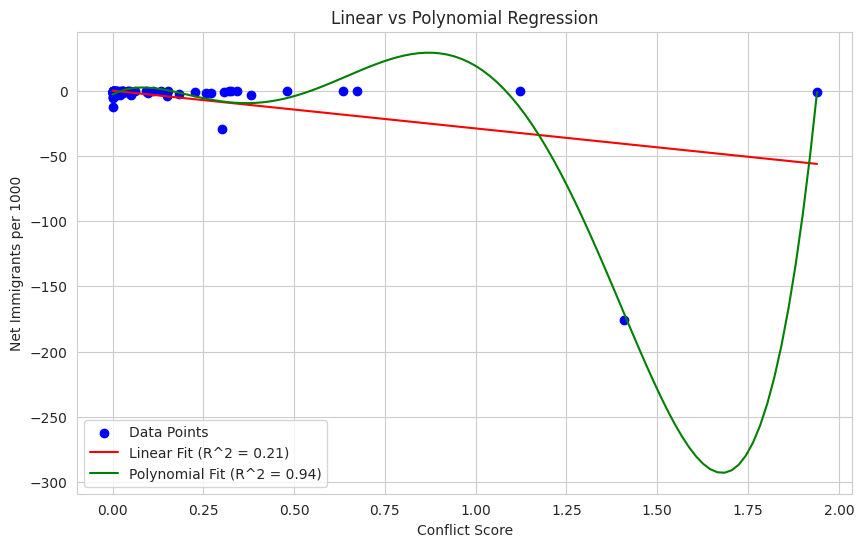

In [1176]:
best_degree = 1
best_r_squared = 0
best_formula = ""

for degree in range(1,7):
    formula = '(net_immigrants_per_1000) ~ ' + ' + '.join([f'np.power({best_predictor}, {i})' for i in range(1, degree + 1)])

    model = smf.ols(formula=formula, data=net_loss_data).fit()
    
    r_squared = model.rsquared
    
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_degree = degree
        best_formula = formula

print(f"The best polynomial degree is: {best_degree}")
print(f"The resulting R-squared value is: {best_r_squared}")
print(f"The best formula is {formula}")

# Linear Regression
X_linear = net_loss_data[['Conflict_Score']]
X_linear = sm.add_constant(X_linear)
y = net_loss_data['net_immigrants_per_1000']
model_linear = sm.OLS(y, X_linear).fit()
r_squared_linear = model_linear.rsquared

# Polynomial Regression
degree = 5
X_poly = np.column_stack([np.power(net_loss_data['Conflict_Score'], i) for i in range(1, degree + 1)])
X_poly = sm.add_constant(X_poly)
model_poly = sm.OLS(y, X_poly).fit()
r_squared_poly = model_poly.rsquared

# Generate predictions for plotting
X_plot = np.linspace(net_loss_data['Conflict_Score'].min(), net_loss_data['Conflict_Score'].max(), 100)
X_plot_poly = np.column_stack([np.power(X_plot, i) for i in range(1, degree + 1)])
X_plot_poly = sm.add_constant(X_plot_poly)

y_linear_pred = model_linear.predict(sm.add_constant(X_plot))
y_poly_pred = model_poly.predict(X_plot_poly)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(net_loss_data['Conflict_Score'], net_loss_data['net_immigrants_per_1000'], color='blue', label='Data Points')
plt.plot(X_plot, y_linear_pred, color='red', label=f'Linear Fit (R^2 = {r_squared_linear:.2f})')
plt.plot(X_plot, y_poly_pred, color='green', label=f'Polynomial Fit (R^2 = {r_squared_poly:.2f})')
plt.xlabel('Conflict Score')
plt.ylabel('Net Immigrants per 1000')
plt.title('Linear vs Polynomial Regression')
plt.legend()
plt.show()


We see an extremely significant improvement in R-Squared with a polynomial regression that is clearly overfit based on an outlying data point. 

In [1116]:
best_degree = 1
best_r_squared = 0
best_formula = ""
predictor = "GPI_2022"
for degree in range(1,11):
    formula = '(net_immigrants_per_1000) ~ ' + ' + '.join([f'np.power({predictor}, {i})' for i in range(1, degree + 1)])

    model = smf.ols(formula=formula, data=net_loss_data).fit()
    
    r_squared = model.rsquared
    
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_degree = degree
        best_formula = formula

print(f"The best polynomial degree is: {best_degree}")
print(f"The resulting R-squared value is: {best_r_squared}")
print(f"The best formula is {formula}")

The best polynomial degree is: 10
The resulting R-squared value is: 0.18106710631166256
The best formula is (net_immigrants_per_1000) ~ np.power(GPI_2022, 1) + np.power(GPI_2022, 2) + np.power(GPI_2022, 3) + np.power(GPI_2022, 4) + np.power(GPI_2022, 5) + np.power(GPI_2022, 6) + np.power(GPI_2022, 7) + np.power(GPI_2022, 8) + np.power(GPI_2022, 9) + np.power(GPI_2022, 10)


Now for the positive cases

In [1179]:
best_predictor = ''
best_r_squared = 0
r_squareds = []

net_gain_data = master_frame[master_frame['net_immigrants_per_1000'] > 0]

# Target variable
y = net_gain_data['net_immigrants_per_1000']

for feature in net_loss_data.columns:
    if feature != 'Absolute_Net_Immigrants' and feature != "Country" and feature != "net_immigrants_per_1000":
        X = net_gain_data[[feature]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        r_squareds.append((feature, r_squared))

        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_predictor = feature

sorted_r = sorted(r_squareds, key=lambda x: x[1])
sorted_r = reversed(sorted_r)
for item in sorted_r:
    print(f"{item[0]}: {item[1]}")

Health_and_Wellness: 0.04376543077722761
GDP_per_Capita: 0.03133293095853451
Access_to_Basic_Knowledge: 0.018988332371742245
Shelter: 0.011865187712040925
Environmental_Quality: 0.011160852883964512
Nutrition_and_Basic_Medical_Care: 0.010224184926732605
Personal_Safety: 0.008807291699020392
Conflict_Index: 0.008316222204476587
Population: 0.008301512283679702
Basic_Human_Needs: 0.006086694079163402
Inclusiveness: 0.0055450493398343514
Personal_Rights: 0.004609403958833358
Conflict_Score: 0.004568681550373044
Personal_Freedom_and_Choice: 0.004427936765633023
GPI_2022: 0.0025756103416183507
Foundations_of_Wellbeing: 0.0008469550180185692
Access_to_Information_and_Communications: 0.0007470363057408003
Opportunity: 0.00024689454233006725
Water_and_Sanitation: 0.00015816847541094692
Social_Progress_Score: 2.2116398003424464e-05
Access_to_Advanced_Education: 7.903320350388654e-07


In [1185]:
best_degree = 1
best_r_squared = 0
best_formula = ""

for degree in range(1,6):
    formula = '(net_immigrants_per_1000) ~ ' + ' + '.join([f'np.power({best_predictor}, {i})' for i in range(1, degree + 1)])

    model = smf.ols(formula=formula, data=net_gain_data).fit()
    
    r_squared = model.rsquared
    
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_degree = degree
        best_formula = formula

print(f"The best polynomial degree is: {best_degree}")
print(f"The resulting R-squared value is: {best_r_squared}")
print(f"The best formula is {formula}")

The best polynomial degree is: 5
The resulting R-squared value is: 0.24671634443597024
The best formula is (net_immigrants_per_1000) ~ np.power(Health_and_Wellness, 1) + np.power(Health_and_Wellness, 2) + np.power(Health_and_Wellness, 3) + np.power(Health_and_Wellness, 4) + np.power(Health_and_Wellness, 5)


In [1187]:
formula = 'net_immigrants_per_1000 ~ Health_and_Wellness + Access_to_Basic_Knowledge + GDP_per_Capita'
model = smf.ols(formula=formula, data=net_gain_data).fit()

# Print the summary of the model
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     net_immigrants_per_1000   R-squared:                       0.254
Model:                                 OLS   Adj. R-squared:                  0.204
Method:                      Least Squares   F-statistic:                     5.102
Date:                     Sun, 15 Sep 2024   Prob (F-statistic):            0.00400
Time:                             14:33:05   Log-Likelihood:                -228.78
No. Observations:                       49   AIC:                             465.6
Df Residuals:                           45   BIC:                             473.1
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

## Intepretation
So far we have seen that the ACLED Conflict Score can be quite accurate in fitting negative rates of immigration - meaning the data suggests that why people would leave a country is fairly one-dimensional. What is interesting here is that low rates of other "Progress" scores don't seem to help us much in fitting a model for whether people leave a country. On the other hand, no single progress scores or GDP can tell us much about why a country would be a desirable place to emigrate to. The story for why a country may see an influx of migrants appears to be far more complex, supporting our hypothesis.

In [1220]:
import itertools

# Define the target variable
y = net_gain_data['net_immigrants_per_1000']

# Define the features
features = net_gain_data.columns.tolist()

features.remove("net_immigrants_per_1000")
features.remove("Country")
features.remove("Absolute_Net_Immigrants")
features.remove("Population")
features.remove("Basic_Human_Needs")
features.remove("Inclusiveness")
features.remove("Personal_Rights")
features.remove("Conflict_Index")
features.remove("Personal_Freedom_and_Choice")
#features.remove("GPI_2022")
features.remove("Foundations_of_Wellbeing")
features.remove("Access_to_Information_and_Communications")
features.remove("Opportunity")
features.remove("Water_and_Sanitation")
#features.remove("Access_to_Advanced_Education")
features.remove("Social_Progress_Score")
"""
Population: 0.008301512283679702
Basic_Human_Needs: 0.006086694079163402
Inclusiveness: 0.0055450493398343514
Personal_Rights: 0.004609403958833358
Conflict_Score: 0.004568681550373044
Personal_Freedom_and_Choice: 0.004427936765633023
GPI_2022: 0.0025756103416183507
Foundations_of_Wellbeing: 0.0008469550180185692
Access_to_Information_and_Communications: 0.0007470363057408003
Opportunity: 0.00024689454233006725
Water_and_Sanitation: 0.00015816847541094692
Social_Progress_Score: 2.2116398003424464e-05
Access_to_Advanced_Education: 7.903320350388654e-07
"""
# Generate all possible combinations of features
feature_combinations = []
for i in range(1, len(features) + 1):
    feature_combinations.extend(itertools.combinations(features, i))

# Initialize variables to store the best model information
best_r_squared = 0
best_features = []
r_squareds = []

# Fit models for each combination of features and evaluate
for feature_set in feature_combinations:
    X = net_gain_data[list(feature_set)]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    r_squared = round(model.rsquared,2)
    r_squareds.append((feature_set, r_squared))
    
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_features = feature_set

# Process
sorted_r = sorted(r_squareds, key=lambda x: x[1])
sorted_r = reversed(sorted_r)
top_sets = []
for feature_set, r in sorted_r:
    if r >= best_r_squared-.01:
        top_sets.append(feature_set)
print(f"Best R-Squared: {best_r_squared}")

flattened_list = [item for sublist in top_sets for item in sublist]
unique_features = set(flattened_list)
print(f"Features found in best formulas: {unique_features}")
smallest_set = min(top_sets,key=len)
print(f"Most compact formula with high r-squared: {smallest_set}")

#i = 0
#for item in sorted_r:
#    print(f"{item[0]}: {item[1]}")
#    i += 1
    
#print(f"Best Feature Sets")
#for i in range(0,10):
#    print(f"Features: {sorted_r[i][0]}, R-squared: {sorted_r[i][1]}")
#print(f"Best R-squared: {best_r_squared}")
#print("All R-squared values:")
#for feature_set, r_squared in r_squareds:
#    print(f"Features: {feature_set}, R-squared: {r_squared}")


Best R-Squared: 0.58
Features found in best formulas: {'Shelter', 'Access_to_Basic_Knowledge', 'Access_to_Advanced_Education', 'Health_and_Wellness', 'Conflict_Score', 'Nutrition_and_Basic_Medical_Care', 'Environmental_Quality', 'GDP_per_Capita', 'Personal_Safety', 'GPI_2022'}
Most compact formula with high r-squared: ('Personal_Safety', 'Access_to_Basic_Knowledge', 'Health_and_Wellness', 'Environmental_Quality', 'Access_to_Advanced_Education')


# Conclusion
